In [1]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_parquet('../../data/cleaned_tom/hi_tom_train_2000.parquet')
dfh = pd.read_parquet('../../data/cleaned_tom/hi_tom_explore_tom_test_hint.parquet')
dfe = pd.read_parquet('../data/ToM_train_800.parquet')

In [4]:
print(len(df), len(dfh), len(dfe))

2000 1600 800


In [16]:
dfe['data_source'] = 'explore_tom'

In [5]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   deception       2000 non-null   bool  
 1   story_length    2000 non-null   int64 
 2   question_order  2000 non-null   int64 
 3   sample_id       2000 non-null   int64 
 4   story           2000 non-null   object
 5   question        2000 non-null   object
 6   choices         2000 non-null   object
 7   answer          2000 non-null   object
 8   question_old    2000 non-null   object
 9   answer_old      2000 non-null   object
 10  data_source     2000 non-null   object
 11  prompt          2000 non-null   object
 12  ability         2000 non-null   object
 13  reward_model    2000 non-null   object
 14  extra_info      2000 non-null   object
dtypes: bool(1), int64(3), object(11)
memory usage: 220.8+ KB


In [7]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   story_structure     800 non-null    object
 1   infilled_story      800 non-null    object
 2   question            800 non-null    object
 3   answer              800 non-null    object
 4   question_type       800 non-null    object
 5   params              800 non-null    object
 6   nth_order           800 non-null    int64 
 7   is_interesting      800 non-null    bool  
 8   story_type          800 non-null    object
 9   story_structure_wn  800 non-null    object
dtypes: bool(1), int64(1), object(8)
memory usage: 57.2+ KB


In [8]:
dfs = df.groupby(['answer']).story.count().reset_index()

In [9]:
dfs = dfs.sort_values(by='story', ascending=False, ignore_index=True)
dfs.head(20)

,answer,story
0,blue_drawer,84
1,green_basket,82
2,red_drawer,80
3,red_bottle,79
4,green_bottle,77
5,green_box,77
6,blue_bucket,75
7,blue_treasure_chest,74
8,red_bucket,73
9,green_suitcase,73


In [10]:
df.question[:10]

0    Where does Lily think Gracie thinks Jackson th...
1    Where does Noah think Emily thinks Mila thinks...
2          Where does Oliver really think the peas is?
3    Where does Isabella think Amelia thinks the ap...
4    Where does Mason think Olivia thinks Nathan th...
5                            Where is the peas really?
6    Where does Gracie think Jackson thinks the pum...
7    Where does Isabella think Amelia thinks the on...
8    Where does Isla think Elizabeth thinks the pin...
9    Where does Alexander really think the broccoli...
Name: question, dtype: object

In [11]:
#SYSTEM_PROMPT = """You are a helpful assistant. First, think through the question internally before providing the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>"""

SYSTEM_PROMPT = """You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>."""

In [12]:
XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [13]:
def get_prompts(dft):
    prompt = []
    for i in range(len(dft)):
        if dft['data_source'][i] == 'explore_tom':
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story_structure'][i], dft['question'][i])}
                ])
        else:
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story'][i], dft['question'][i])}
                ])
    return prompt

In [17]:
prompts = get_prompts(df)
df['prompt'] = prompts

prompts = get_prompts(dfe)
dfe['prompt'] = prompts

prompts = get_prompts(dfh)
dfh['prompt'] = prompts

In [18]:
dfe.head(2)

,story_structure,infilled_story,question,answer,question_type,params,nth_order,is_interesting,story_type,story_structure_wn,data_source,prompt
0,Elijah entered the multipurpose room. Bryce en...,"The community center's multipurpose room, with...",In which container is the harmonica now?,wooden chest,ground_truth-container_location,"(None, 'harmonica', 'ground_truth-container_lo...",-1,True,tomi+object-state,1 Elijah entered the multipurpose room\n2 Bryc...,explore_tom,"[{'role': 'system', 'content': 'You are a help..."
1,Kennedy entered the operations room. Colton en...,"Deep within a heavily fortified military base,...",In which room does Jessica think that Riley wi...,operations room,room_location-True,"(['Jessica', 'Riley'], 'metal toolbox', 'room_...",2,False,tomi+info-exchange,1 Kennedy entered the operations room\n2 Colto...,explore_tom,"[{'role': 'system', 'content': 'You are a help..."


In [19]:
df.head(2)

,deception,story_length,question_order,sample_id,story,question,choices,answer,question_old,answer_old,data_source,prompt,ability,reward_model,extra_info
0,True,2,3,96,"Lily, Hannah, Emma, Jackson and Gracie entered...",Where does Lily think Gracie thinks Jackson th...,"A. green_drawer, B. red_container, C. blue_box...",green_cupboard,Where does Lily think Gracie thinks Jackson th...,green_cupboard,hi_tom,"[{'role': 'system', 'content': 'You are a help...",theory_of_mind,"{'ground_truth': 'green_cupboard', 'style': 'r...","{'deception': True, 'question_order': 3, 'stor..."
1,False,1,3,29,"Mila, Benjamin, Emily, Noah and Isabella enter...",Where does Noah think Emily thinks Mila thinks...,"A. red_crate, B. red_bottle, C. blue_drawer, D...",red_crate,Where does Noah think Emily thinks Mila thinks...,red_crate,hi_tom,"[{'role': 'system', 'content': 'You are a help...",theory_of_mind,"{'ground_truth': 'red_crate', 'style': 'rule'}","{'deception': False, 'question_order': 3, 'sto..."


In [21]:
col = ['prompt', 'answer', 'data_source']

In [30]:
dfr = pd.concat([df.loc[:, col], dfe.loc[:, col]], ignore_index=True)
dfr = dfr.sample(frac=1, replace=False, ignore_index=True)

In [31]:
data = Dataset.from_pandas(dfr)

In [32]:
len(data['prompt'])

2800

<Axes: ylabel='Count'>

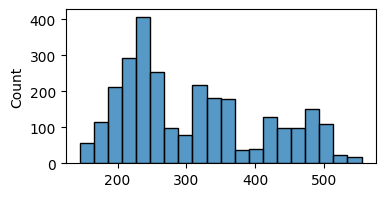

In [33]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [34]:
data

Dataset({
    features: ['prompt', 'answer', 'data_source'],
    num_rows: 2800
})

In [35]:
data.to_parquet('../data/train/ToM_train_HiEx.parquet')

Creating parquet from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 541.74ba/s]


4007262